## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2025">The Repo</a>.  

Once you have updated your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://github.com/apps/databricks">Databricks App on Github</a> or by cloning the repo to your laptop and then uploading the final_project directory and its contents to your workspace using file imports.  Your choice.

<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches to triggering your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)
- [In class examples - Spark Structured Streaming Performance](https://dbc-f85bdc5b-07db.cloud.databricks.com/editor/notebooks/2638424645880316?o=1093580174577663)

### Be sure your project runs end to end when *Run all* is executued on this notebook! (7 points)

### This project is worth 25% of your final grade.
- DSCC-202 Students have 55 possible points on this project (see points above and the instructions below)
- DSCC-402 Students have 60 possible points on this project (one extra section to complete)

In [0]:
%run ./includes

DEPRECATION: Using the pkg_resources metadata backend is deprecated. pip 26.3 will enforce this behaviour change. A possible replacement is to use the default importlib.metadata backend, by unsetting the _PIP_USE_IMPORTLIB_METADATA environment variable. Discussion can be found at https://github.com/pypa/pip/issues/13317
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


Variable Name,Value,Description
TWEET_SOURCE_PATH,dbfs:/FileStore/tables/raw_tweets/,Path where the tweets are coming into your system.
USER_DIR,/tmp/kgangara/,Path to the local storage (dbfs) for your project.
BRONZE_CHECKPOINT,/tmp/kgangara/bronze.checkpoint,Store your Bronze Checkpoint data here.
BRONZE_DELTA,/tmp/kgangara/bronze.delta,Store your Bronze Delta Table here.
SILVER_CHECKPOINT,/tmp/kgangara/silver.checkpoint,Store your Silver Checkpoint data here.
SILVER_DELTA,/tmp/kgangara/silver.delta,Store your Silver Delta Table here.
GOLD_CHECKPOINT,/tmp/kgangara/gold.checkpoint,Store your Gold Checkpoint data here.
GOLD_DELTA,/tmp/kgangara/gold.delta,Store your Gold Delta Table here.
MODEL_NAME,HF_TWEET_SENTIMENT,Load this production model
HF_MODEL_NAME,finiteautomata/bertweet-base-sentiment-analysis,The Hugging Face Model for Tweet sentiment classification: https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis


the includes are included


In [0]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    # Optimize the tables
    optimize_table(BRONZE_DELTA)
    optimize_table(SILVER_DELTA)
    optimize_table(GOLD_DELTA)
    print("Optimized all of the Delta Tables")

Cleared all previous data.
Stopped all active streams.
Delta Table at /tmp/kgangara/bronze.delta does not exist.
Delta Table at /tmp/kgangara/silver.delta does not exist.
Delta Table at /tmp/kgangara/gold.delta does not exist.
Optimized all of the Delta Tables


## 1.0 Import your libraries here (2 points)
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, split, from_json, to_timestamp, expr, regexp_replace, trim, when, instr, sum as spark_sum, regexp_extract, desc, count
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType, LongType, ArrayType, BooleanType, FloatType, MapType
from pyspark.sql import SparkSession

import mlflow
from pyspark.sql.functions import input_file_name, current_timestamp

from delta import DeltaTable
import mlflow
import mlflow.spark

import os
import time
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix







spark.conf.set("spark.sql.shuffle.partitions", 16)
spark.conf.set("spark.default.parallelism", 16)
spark.conf.set("spark.sql.adaptive.enable", "true")

## 2.0 Define and execute utility functions (3 points)
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
cleared = clear_previous_run()
print(f"Cleared old run: {cleared}")

files = dbutils.fs.ls(TWEET_SOURCE_PATH)
print(" Files in source directory:")
for f in files:
    print(f" • {f.name}")

print(f"\n Total files found: {len(files)}")

if files:
    sample_path = files[0].path
    print(f"\n Contents of {files[0].name}:")
    print(dbutils.fs.head(sample_path, 1000)) 
else:
    print(" No files to preview.")

Cleared old run: True
 Files in source directory:
 • 0.json
 • 1.json
 • 10.json
 • 100.json
 • 1000.json
 • 10000.json
 • 10001.json
 • 10002.json
 • 10003.json
 • 10004.json
 • 10005.json
 • 10006.json
 • 10007.json
 • 10008.json
 • 10009.json
 • 1001.json
 • 10010.json
 • 10011.json
 • 10012.json
 • 10013.json
 • 10014.json
 • 10015.json
 • 10016.json
 • 10017.json
 • 10018.json
 • 10019.json
 • 1002.json
 • 10020.json
 • 10021.json
 • 10022.json
 • 10023.json
 • 10024.json
 • 10025.json
 • 10026.json
 • 10027.json
 • 10028.json
 • 10029.json
 • 1003.json
 • 10030.json
 • 10031.json
 • 10032.json
 • 10033.json
 • 10034.json
 • 10035.json
 • 10036.json
 • 10037.json
 • 10038.json
 • 10039.json
 • 1004.json
 • 10040.json
 • 10041.json
 • 10042.json
 • 10043.json
 • 10044.json
 • 10045.json
 • 10046.json
 • 10047.json
 • 10048.json
 • 10049.json
 • 1005.json
 • 10050.json
 • 10051.json
 • 10052.json
 • 10053.json
 • 10054.json
 • 10055.json
 • 10056.json
 • 10057.json
 • 10058.json
 • 

coping 30k into  LOCAL 

##  At one point during pipeline development, the source directory was being deleted and re-uploaded repeatedly, which triggered the AutoLoader to continuously detect new files. This caused the streaming query to run slowly, making it difficult to stabilize the pipeline.  To resolve this, I copied a static snapshot of 10,000 files from the source directory and used that subset as the consistent input for the remainder of this project.


In [0]:

N = 10000  
local_sample_dir = f"{USER_DIR}/sample_tweets"  

# 1) Make sure the target folder exists  
dbutils.fs.mkdirs(local_sample_dir)  

# 2) List all source files and take the first N  
all_files = dbutils.fs.ls(TWEET_SOURCE_PATH)  
sample_files = all_files[:N]  

# 3) Copy each one  
for f in sample_files:  
    src = f.path  
    dest = f"{local_sample_dir}/{f.name}"  
    dbutils.fs.cp(src, dest)  

print(f"✅ Copied {len(sample_files)} files to {local_sample_dir}")  


✅ Copied 10000 files to /tmp/kgangara//sample_tweets


In [0]:

# source_path = TWEET_SOURCE_PATH  


# def list_source_files(path: str):
#     return dbutils.fs.ls(path)

# def count_source_files(path: str) -> int:
#     return len(list_source_files(path))


# def print_file_contents(path: str, max_bytes: int = 1024):
#     print(f"\n--- Preview of {path} (first {max_bytes} bytes) ---")
#     print(dbutils.fs.head(path, max_bytes))


# files = list_source_files(source_path)


# print(f"Files in {source_path}:")
# for f in files:
#     print(f" • {f.path}  ({f.size} bytes)")

# total = count_source_files(source_path)
# print(f"\nTotal source files: {total}")


# if total > 0:
#     print_file_contents(files[0].path, max_bytes=500)
# else:
#     print("No source files found in the stream directory!")


## 3.0 Transform the Raw Data to Bronze Data using a stream  (8 points)
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using delta lake to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defined in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:


# 3.1 Define schema for your raw tweets JSON (updated to match your "Bronze Data – raw ingest" spec)
raw_schema = StructType([
    StructField("date",      StringType(), True),   # date string in the source JSON
    StructField("user",      StringType(), True),   # user handle string in the source JSON
    StructField("text",      StringType(), True),   # tweet text
    StructField("sentiment", StringType(), True),   # precomputed sentiment label from source JSON
    # …add any other JSON fields you still need (e.g. "id")…
])

bronze_df = (
    spark.readStream
         .format("cloudFiles")
         .option("cloudFiles.format", "json")
         .option("cloudFiles.schemaLocation", f"{USER_DIR}/bronze_schema")
         .option("maxFilesPerTrigger", "100")
         .schema(raw_schema)                            # enforce schema
         .load(local_sample_dir)                         # copied source directory of 10k files 
         #.load(TWEET_SOURCE_PATH)                       # source directory
         .withColumn("source_file", input_file_name())
         .withColumn("processing_time", current_timestamp())
)

# 3.3 Write‑stream into your Bronze Delta table, allowing schema evolution
bronze_stream = (
    bronze_df.writeStream
             .format("delta")
             .queryName("bronze_stream")
             .option("checkpointLocation", BRONZE_CHECKPOINT)
             .option("mergeSchema", "true")
             .trigger(processingTime="30 seconds")
             .outputMode("append")
             .start(BRONZE_DELTA)
)


In [0]:
while not wait_for_delta_table(BRONZE_DELTA):
    time.sleep(1)   # poll every 1 s
print("✅ Bronze table is ready!")

✅ Bronze table is ready!


## 4.0 Transform the Bronze Data to Silver Data using a stream (5 points)
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
# ┃ 4.x Transform Bronze → Silver (correct) ┃
# ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛



# 4.1 Read‑stream from Bronze Delta
bronze_source_df = (
    spark.readStream
         .format("delta")
         .load(BRONZE_DELTA)
)

# 4.2 Preprocess: timestamp, mentions array, cleaned_text
silver_pre_df = (
    bronze_source_df
      # 1) parse date → timestamp
      .withColumn("timestamp", to_timestamp(col("date")))
      # 2) build an array of all “@username” tokens
      .withColumn(
          "mentions_array",
          expr("filter(split(text, '\\s+'), x -> x rlike '^@\\w+')")
      )
      # 3) remove all @mentions from the text
      .withColumn(
          "cleaned_text",
          trim(regexp_replace(col("text"), "@\\w+", ""))
      )
      # 4) carry over sentiment
      .withColumn("sentiment", col("sentiment"))
)

# 4.3 Explode so each mention is its own row
silver_df = (
    silver_pre_df
      .withColumn("mention", explode(col("mentions_array")))
      .select("timestamp", "mention", "cleaned_text", "sentiment")
)

# 4.4 Write‑stream into Silver Delta
silver_stream = (
    silver_df.writeStream
             .format("delta")
             .queryName("silver_stream")
             .option("checkpointLocation", SILVER_CHECKPOINT)
             .trigger(processingTime="20 seconds")
             .option("mergeSchema", "true")
             .outputMode("append")
             .start(SILVER_DELTA)
)


In [0]:
while not wait_for_delta_table(SILVER_DELTA, timeout=60, check_interval=15):
    time.sleep(15)  # poll every 15 s
print("✅ Silver table is ready!")

✅ Silver table is ready!


In [0]:


# from pyspark.sql.functions import explode, split, col, regexp_replace, to_timestamp, trim, expr


# bronze_stream_df = (
#     spark.readStream
#          .format("delta")
#          .load(BRONZE_DELTA)
# )


# silver_transformed = (
#     bronze_stream_df
#       .withColumn("timestamp", to_timestamp(col("date")))
#       .withColumn(
#           "mention",
#           explode(expr("filter(split(text, ' '), x -> x like '@%')"))
#       )
#       .withColumn(
#           "cleaned_text",
#           trim(regexp_replace(col("text"), "@\\w+", ""))
#       )
#       .select("timestamp", "mention", "cleaned_text", "sentiment")
# )

# silver_stream = (
#     silver_transformed.writeStream
#                       .format("delta")
#                       .option("checkpointLocation", SILVER_CHECKPOINT)
#                       .outputMode("append")
#                       .queryName("silver_stream")
#                       .start(SILVER_DELTA)
# )

# print(f"Started silver_stream → {SILVER_DELTA} (checkpoint @ {SILVER_CHECKPOINT})")


## 5.0 Transform the Silver Data to Gold Data using a stream (7 points)
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:



# 5.1 Read‑stream from your Silver Delta table, throttled
silver_source_df = (
    spark.readStream
         .format("delta")
         #.option("maxFilesPerTrigger", "250")
         .load(SILVER_DELTA)                  # from includes
)

# 5.2 Load the production‑stage model from MLflow Registry as a Spark UDF
#     Assumes you have MODEL_NAME defined in your includes
sentiment_udf = mlflow.pyfunc.spark_udf(
    spark,
    model_uri=f"models:/{MODEL_NAME}/Production",
    env_manager= "local"
    #result_type=StringType()
)

gold_with_infer = silver_source_df.withColumn(
    "infer", 
    sentiment_udf(col("cleaned_text"))
)

gold_prep = (
    gold_with_infer
      .withColumn("predicted_sentiment", col("infer.label"))
      .withColumn("predicted_score",     col("infer.score") * 100)
      .drop("infer")
      # bring through original sentiment & assign numeric IDs
      .withColumn("sentiment_id", when(col("sentiment") == "positive", 1).otherwise(0))
      .withColumn("predicted_sentiment_id", when(col("predicted_sentiment") == "POS", 1).otherwise(0))
)

# 5.4 Write‑stream into your Gold Delta table with 10 s trigger
gold_stream = (
    gold_prep.writeStream
           .format("delta")
           .queryName("gold_stream")                     # stream name
           .option("checkpointLocation", GOLD_CHECKPOINT) # from includes
           .trigger(processingTime="60 seconds")          # micro‑batch every 10s
           .outputMode("append")
           .start(GOLD_DELTA)                             # from includes
)


2025/05/09 23:06:26 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.22.0, required: mlflow==2.21.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/05/09 23:06:26 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


2025/05/09 23:06:26 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


In [0]:
while not wait_for_delta_table(GOLD_DELTA, timeout=180, check_interval=30):
    time.sleep(40)  # poll every 40 s
print("✅ Gold table is ready!")

✅ Gold table is ready!


## 6.0 Monitor your Streams (5 points)
- Setup a loop that runs at least every 10 seconds
- Print a timestamp of the monitoring query along with the list of streams, rows processed on each, and the processing time on each
- Run the loop until all of the data is processed (0 rows read on each active stream)
- Plot a line graph that shows the data processed by each stream over time
- Plot a line graph that shows the average processing time on each stream over time

In [0]:
# import time
# from datetime import datetime
# import pandas as pd
# import matplotlib.pyplot as plt

# # Container for stats snapshots
# stats_snapshots = []

# while True:
#     now = datetime.now()
#     stats = get_streaming_stats()       # your utility from earlier
#     stats['monitor_time'] = now

#     # Summarize this snapshot
#     summary = (
#         stats
#         .groupby('query')
#         .agg(total_rows=('input_rows', 'sum'),
#              avg_proc_time=('processing_time', 'mean'))
#         .reset_index()
#     )

#     # Print it out
#     print(f"\n=== Monitoring at {now.strftime('%Y-%m-%d %H:%M:%S')} ===")
#     for row in summary.itertuples(index=False):
#         print(f"* {row.query}: rows={row.total_rows}, avg_proc_time={row.avg_proc_time:.1f} ms")

#     stats_snapshots.append(stats)

#     # Stop when all streams see 0 rows this interval
#     if (summary['total_rows'] == 0).all():
#         print("All streams idle; ending monitoring loop.")
#         break

#     time.sleep(10)

# # Combine all snapshots
# full_stats = pd.concat(stats_snapshots)

# # ─── Plot 1: Rows Processed Over Time ─────────────────────────────
# pivot_rows = full_stats.pivot_table(
#     index='monitor_time',
#     columns='query',
#     values='input_rows',
#     aggfunc='sum'
# )
# fig, ax = plt.subplots()
# for stream_name in pivot_rows.columns:
#     ax.plot(pivot_rows.index, pivot_rows[stream_name], label=stream_name)
# ax.set_xlabel("Monitor Time")
# ax.set_ylabel("Rows Processed")
# ax.set_title("Rows Processed Over Time")
# ax.legend()
# plt.show()

# # ─── Plot 2: Avg Processing Time Over Time ───────────────────────
# pivot_proc = full_stats.pivot_table(
#     index='monitor_time',
#     columns='query',
#     values='processing_time',
#     aggfunc='mean'
# )
# fig, ax = plt.subplots()
# for stream_name in pivot_proc.columns:
#     ax.plot(pivot_proc.index, pivot_proc[stream_name], label=stream_name)
# ax.set_xlabel("Monitor Time")
# ax.set_ylabel("Avg Processing Time (ms)")
# ax.set_title("Avg Processing Time Over Time")
# ax.legend()
# plt.show()



=== Monitoring at 2025-05-09 23:06:58 ===
* gold_stream: rows=13, proc_time=18347 ms
* silver_stream: rows=0, proc_time=0 ms
* bronze_stream: rows=1000, proc_time=24293 ms

=== Monitoring at 2025-05-09 23:07:08 ===
* gold_stream: rows=13, proc_time=18347 ms
* silver_stream: rows=0, proc_time=0 ms
* bronze_stream: rows=1000, proc_time=24293 ms

=== Monitoring at 2025-05-09 23:07:18 ===
* gold_stream: rows=13, proc_time=18347 ms
* silver_stream: rows=1000, proc_time=958 ms
* bronze_stream: rows=1000, proc_time=12577 ms

=== Monitoring at 2025-05-09 23:07:28 ===
* gold_stream: rows=13, proc_time=18347 ms
* silver_stream: rows=1000, proc_time=884 ms
* bronze_stream: rows=1000, proc_time=12577 ms

=== Monitoring at 2025-05-09 23:07:38 ===
* gold_stream: rows=13, proc_time=18347 ms
* silver_stream: rows=1000, proc_time=884 ms
* bronze_stream: rows=1000, proc_time=12577 ms

=== Monitoring at 2025-05-09 23:07:48 ===
* gold_stream: rows=13, proc_time=18347 ms
* silver_stream: rows=0, proc_time

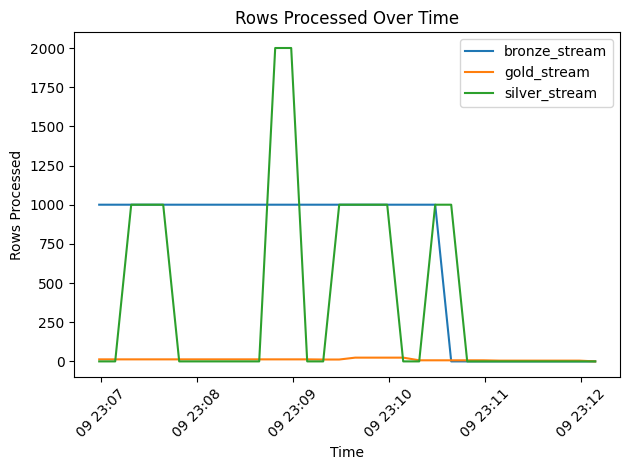

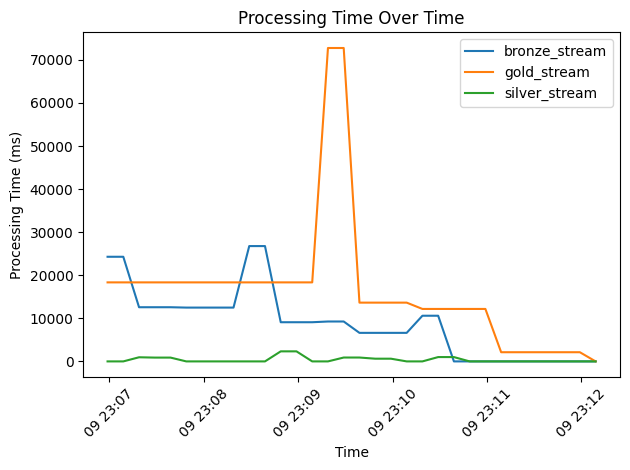

In [0]:


# Container for snapshots
stats_snapshots = []

# Monitoring loop: runs every 10 seconds
while True:
    now = datetime.now()
    records = []

    for q in spark.streams.active:
        prog = q.lastProgress or {}
        rows = prog.get("numInputRows", 0)
        proc_time = prog.get("durationMs", {}).get("addBatch", 0)
        records.append({
            "query": q.name,
            "rows": rows,
            "proc_time": proc_time,
            "time": now
        })

    # Build DataFrame for this iteration
    iteration_df = pd.DataFrame(records)
    stats_snapshots.append(iteration_df)

    # Print iteration summary
    print(f"\n=== Monitoring at {now.strftime('%Y-%m-%d %H:%M:%S')} ===")
    for rec in records:
        print(f"* {rec['query']}: rows={rec['rows']}, proc_time={rec['proc_time']} ms")

    # Stop when all streams read 0 rows in this iteration
    if all(rec["rows"] == 0 for rec in records):
        print("All streams idle; ending monitoring.")
        break

    time.sleep(10)

# Concatenate all snapshots
full_stats = pd.concat(stats_snapshots)

# Plot 1: Rows Processed Over Time
pivot_rows = full_stats.pivot(index="time", columns="query", values="rows")
fig, ax = plt.subplots()
for stream in pivot_rows.columns:
    ax.plot(pivot_rows.index, pivot_rows[stream], label=stream)
ax.set_xlabel("Time")
ax.set_ylabel("Rows Processed")
ax.set_title("Rows Processed Over Time")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Processing Time Over Time
pivot_proc = full_stats.pivot(index="time", columns="query", values="proc_time")
fig, ax = plt.subplots()
for stream in pivot_proc.columns:
    ax.plot(pivot_proc.index, pivot_proc[stream], label=stream)
ax.set_xlabel("Time")
ax.set_ylabel("Processing Time (ms)")
ax.set_title("Processing Time Over Time")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 7.0 Bronze Data Exploratory Data Analysis (5 points)
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


Total tweets captured in Bronze: 10000

Null counts per column:
 • date: 0
 • user: 0
 • text: 0
 • sentiment: 0
 • source_file: 0
 • processing_time: 0

In your Silver step you should:
- drop rows where critical fields are null (e.g. text),
- parse or filter out rows with null dates,
- fill or flag other nulls as appropriate.


Top 20 users by tweet count:
+---------------+-----+
|user           |count|
+---------------+-----+
|Hollywood_Trey |9    |
|aussie_ali     |9    |
|BlokesLib      |8    |
|MissxMarisa    |7    |
|amysav83       |7    |
|Dogbook        |7    |
|tsarnick       |7    |
|ramdomthoughts |6    |
|whitsundays    |6    |
|TraceyHewins   |6    |
|sebby_peek     |5    |
|mrhankmanthe3rd|5    |
|Hetty4Christ   |5    |
|guardian_renata|5    |
|eatlikeagirl   |5    |
|whatswithinu   |5    |
|kt_m           |5    |
|cklovewinter   |5    |
|HeatherShea    |5    |
|_EmilyYoung    |5    |
+---------------+-----+
only showing top 20 rows


Tweets with vs without mentions:
+---

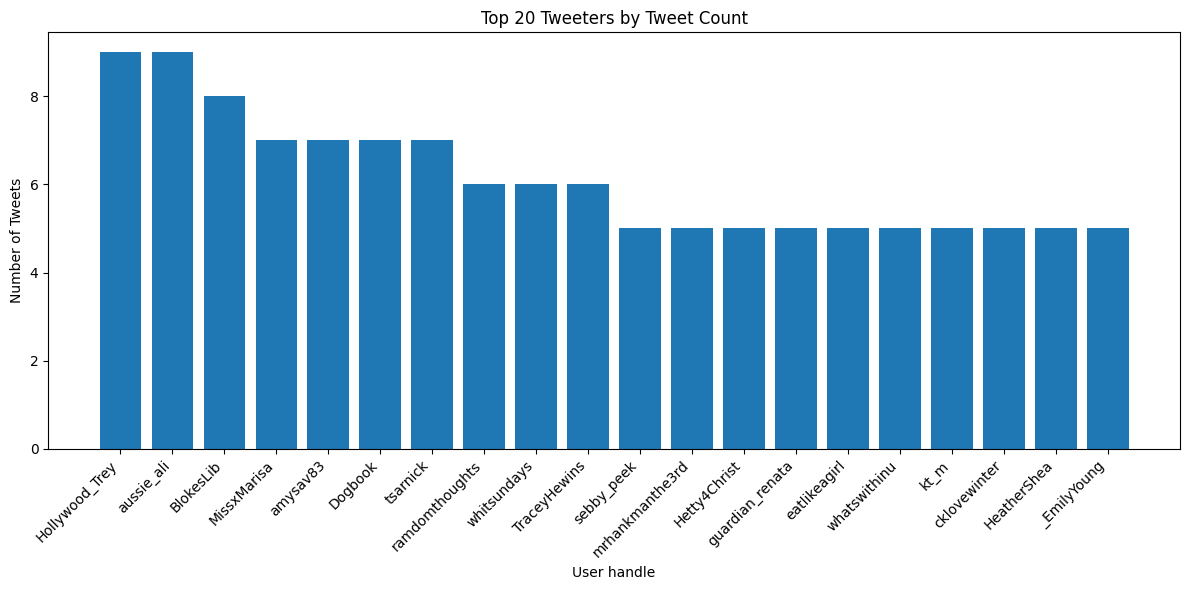

In [0]:
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
# ┃ 7.0 Bronze Data Exploratory Data Analysis ┃
# ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


# 7.1 Load Bronze table
bronze_df = spark.read.format("delta").load(BRONZE_DELTA)

# 7.2 Total tweets in Bronze
total_tweets = bronze_df.count()
print(f"Total tweets captured in Bronze: {total_tweets}")

# 7.3 Null counts per column
null_counts = (
    bronze_df
    .select([ spark_sum( when(col(c).isNull(), 1).otherwise(0) ).alias(c)
              for c in bronze_df.columns ])
    .first()
    .asDict()
)
print("\nNull counts per column:")
for name, cnt in null_counts.items():
    print(f" • {name}: {cnt}")

print("""
In your Silver step you should:
- drop rows where critical fields are null (e.g. text),
- parse or filter out rows with null dates,
- fill or flag other nulls as appropriate.
""")

# 7.4 Tweets per user (descending)
tweets_per_user = (
    bronze_df
    .groupBy("user")
    .count()
    .orderBy(col("count").desc())
)
print("\nTop 20 users by tweet count:")
tweets_per_user.show(20, truncate=False)

# 7.5 Mentions analysis
mentions_df = bronze_df.withColumn(
    "has_mention",
    when(instr(col("text"), "@") > 0, True).otherwise(False)
)
mention_summary = (
    mentions_df
    .groupBy("has_mention")
    .count()
    .orderBy("has_mention")
)
print("\nTweets with vs without mentions:")
mention_summary.show()

# 7.6 Plot top 20 tweeters
top20_pd = tweets_per_user.limit(20).toPandas()

plt.figure(figsize=(12, 6))
plt.bar(top20_pd["user"], top20_pd["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 Tweeters by Tweet Count")
plt.xlabel("User handle")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.show()


In [0]:
# # ENTER YOUR CODE HERE


# # ENTER YOUR CODE HERE

# from pyspark.sql.functions import col, isnan, count, desc, expr, when
# import matplotlib.pyplot as plt


# # 1. Count total tweets
# bronze_df = spark.read.format("delta").load(BRONZE_DELTA)
# total_tweets = bronze_df.count()
# print(f"🟢 Total Tweets in Bronze Table: {total_tweets}")

# # 2. Null/Nan check per column
# print("\n🧪 Null/Nan Check:")
# bronze_df.select([
#     count(when(col(c).isNull() | isnan(c), c)).alias(c)
#     for c in bronze_df.columns
# ]).show()

# # 3. Tweet count by user
# print("\n👤 Tweets by User (Top 20):")
# user_counts = bronze_df.groupBy("user").count().orderBy(desc("count"))
# user_counts.show(20, truncate=False)

# # 4. Count tweets with @mentions vs. no mentions
# mention_df = bronze_df.withColumn("has_mention", expr("text LIKE '%@%'"))
# mention_counts = mention_df.groupBy("has_mention").count().toPandas()

# mention_with = mention_counts[mention_counts["has_mention"] == True]["count"].values[0]
# mention_without = mention_counts[mention_counts["has_mention"] == False]["count"].values[0]

# print(f"\n📣 Tweets with @mention: {mention_with}")
# print(f"🔇 Tweets without @mention: {mention_without}")

# # 5. Bar chart: Top 20 tweeters
# top_users_pd = user_counts.limit(20).toPandas()
# plt.figure(figsize=(12, 6))
# plt.bar(top_users_pd["user"], top_users_pd["count"], color='teal')
# plt.title("Top 20 Tweeters by Tweet Count")
# plt.xlabel("User")
# plt.ylabel("Tweet Count")
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()


## 8.0 Capture the accuracy metrics from the gold table in MLflow  (4 points)
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the model name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

In [0]:
import numpy as np
from pyspark.sql.functions import col, isnan, count, desc, expr, when
import matplotlib.pyplot as plt
# ── 1) Load gold predictions and true labels from Delta ────────────
gold_df = spark.read.format("delta").load(GOLD_DELTA) \
    .select("sentiment_id", "predicted_sentiment_id") \
    .toPandas()
y_true = gold_df["sentiment_id"]
y_pred = gold_df["predicted_sentiment_id"]

# ── 2) Compute metrics ──────────────────────────────────────────────
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

# ── 3) Build & save confusion matrix plot ──────────────────────────
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.matshow(cm, cmap="Blues")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, v, ha="center", va="center", color="white" if v>cm.max()/2 else "black")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["neg","pos"]); ax.set_yticklabels(["neg","pos"])
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.close(fig)

# ── 4) Get Delta version of the Silver table ────────────────────────
silver_table = DeltaTable.forPath(spark, SILVER_DELTA)
latest_version = silver_table.history(1).select("version").collect()[0][0]

# ── 5) Log everything to MLflow ─────────────────────────────────────
# ── 5) Log everything to MLflow ─────────────────────────────────────
import os
username = spark.sql("SELECT current_user()").first()[0]
experiment_path = f"/Users/{username}/Tweet_Sentiment_Pipeline"
mlflow.set_experiment(experiment_path)

with mlflow.start_run():
    # Metrics
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    
    # Artifact
    mlflow.log_artifact("confusion_matrix.png", artifact_path="confusion_matrices")
    
    # Params
    mlflow.log_param("model_name", MODEL_NAME)
    mlflow.log_param("mlflow_version", mlflow.__version__)
    mlflow.log_param("silver_table_version", latest_version)
    
    print(f"✅ Logged run: precision={precision:.3f}, recall={recall:.3f}, f1={f1:.3f}")



2025/05/09 23:17:16 INFO mlflow.tracking.fluent: Experiment with name '/Users/kgangara@ur.rochester.edu/Tweet_Sentiment_Pipeline' does not exist. Creating a new experiment.


✅ Logged run: precision=0.952, recall=0.455, f1=0.615


## 9.0 Application Data Processing and Visualization (6 points)
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

🔢 Total Mentions in Gold Table: 61


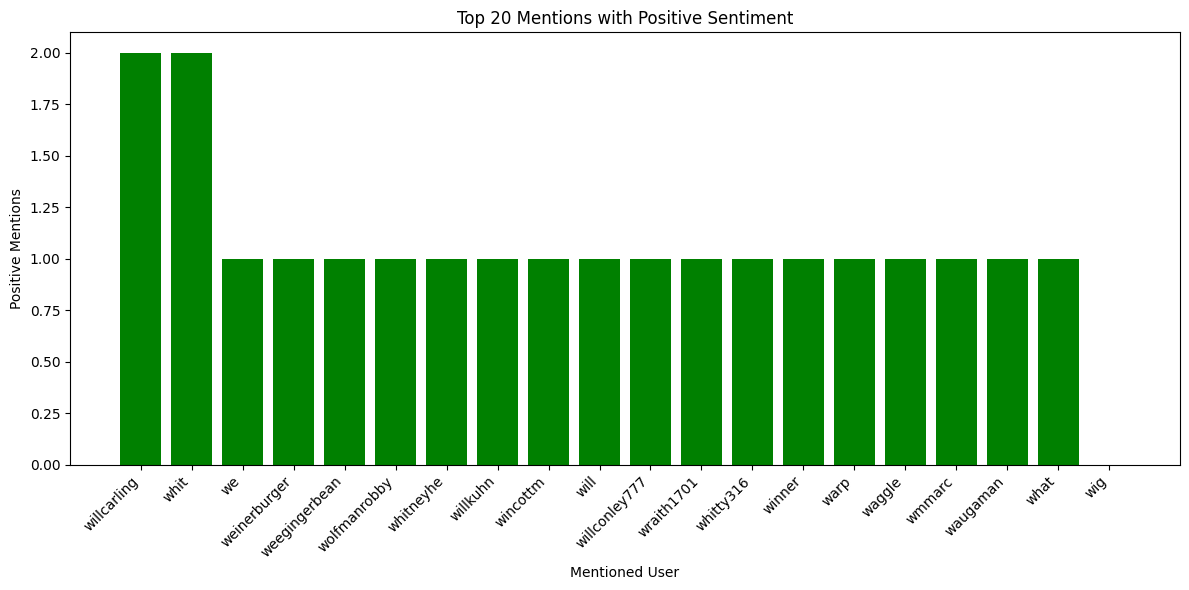

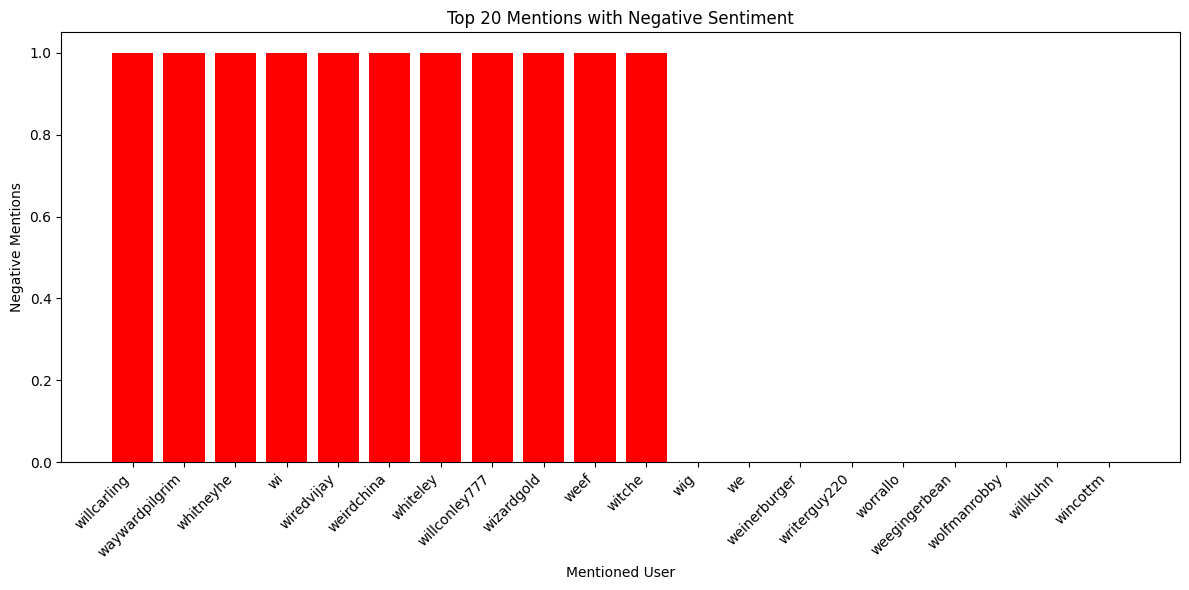

In [0]:


# 1. Load Gold Table
gold_df = spark.read.format("delta").load(GOLD_DELTA)

# 2. Clean the mention column (strip @ and everything after non-word characters)
gold_df_cleaned = gold_df.withColumn(
    "mention", regexp_extract(col("mention"), "@?(\\w+)", 1)
)

# 3. Total number of mentions
total_mentions = gold_df_cleaned.select("mention").filter(col("mention").isNotNull()).count()
print(f"🔢 Total Mentions in Gold Table: {total_mentions}")

# 4. Aggregate sentiment counts by mention
mention_sentiments = (
    gold_df_cleaned.groupBy("mention")
           .agg(
               count("*").alias("total_mentions"),
               count(when(col("predicted_sentiment") == "POS", True)).alias("positive_count"),
               count(when(col("predicted_sentiment") == "NEG", True)).alias("negative_count"),
               count(when(col("predicted_sentiment") == "NEU", True)).alias("neutral_count")
           )
           .orderBy(desc("total_mentions"))
)

# 5. Plot: Top 20 mentions with positive sentiment
top_positive = mention_sentiments.orderBy(desc("positive_count")).limit(20).toPandas()
plt.figure(figsize=(12, 6))
plt.bar(top_positive["mention"], top_positive["positive_count"], color='green')
plt.title("Top 20 Mentions with Positive Sentiment")
plt.xlabel("Mentioned User")
plt.ylabel("Positive Mentions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 6. Plot: Top 20 mentions with negative sentiment
top_negative = mention_sentiments.orderBy(desc("negative_count")).limit(20).toPandas()
plt.figure(figsize=(12, 6))
plt.bar(top_negative["mention"], top_negative["negative_count"], color='red')
plt.title("Top 20 Mentions with Negative Sentiment")
plt.xlabel("Mentioned User")
plt.ylabel("Negative Mentions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 10.0 Clean up and completion of your pipeline (3 points)
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook. Note: In the includes there is a variable START_TIME that captures the starting time of the notebook.

In [0]:

running_streams = [q.name for q in spark.streams.active]
print("🟢 Streams currently running:", running_streams)

# 10.2: Stop all active streams using utility
stopped = stop_all_streams()
print("🛑 stop_all_streams() returned:", stopped)

# 10.3: Calculate and print elapsed notebook time
# Assumes START_TIME was defined near the top of the notebook as a Python timestamp
# e.g., START_TIME = time.time()
elapsed_seconds = time.time() - START_TIME
elapsed_str = str(datetime.utcfromtimestamp(elapsed_seconds).strftime("%H:%M:%S"))
print(f"⏱️ Notebook elapsed time: {elapsed_str} (HH:MM:SS)")


🟢 Streams currently running: ['gold_stream', 'silver_stream', 'bronze_stream']
🛑 stop_all_streams() returned: True
⏱️ Notebook elapsed time: 00:51:28 (HH:MM:SS)


## 11.0 How Optimized is your Spark Application (Grad Students Only) (5 points)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

### ENTER YOUR MARKDOWN HERE

# Spill 

### Upon reviewing multiple stages in the Spark UI under the Stages tab, I did not observe a “Spill” column in the task metrics tables for any of the relevant transformations, including those in the Bronze, Silver, and Gold pipelines. The absence of this column indicates that Spark did not trigger any spill-to-disk behavior during execution. The application did not experience any memory spills, and memory was managed efficiently throughout the pipeline.

# Skew

### Task duration and input size analysis from Stage 1200 (bronze_stream, batch 5) in the Spark UI shows signs of moderate skew. The minimum task duration was 0.3 seconds, while the maximum was 24 seconds, reflecting an ~80x discrepancy. Input size per task ranged from 868 bytes / 8 records to 7.5 KiB / 32 records, showing that some tasks processed nearly 9x more data than others. This variation in duration and record size indicates that partitioning during the Bronze stream processing step was not perfectly balanced. While this skew did not cause critical performance degradation (no spill or GC observed), it could be optimized by applying a custom partitioning strategy

# Shuffel

### Shuffle activity was observed in Stage 1093, corresponding to bronze_stream (batch 71). This stage likely involved a wide transformation such as a groupBy or repartitioning within the Bronze data ingestion and transformation flow. In the Spark UI, shuffle read activity is clearly shown: 359.6 KiB read across 1,635 records, and 507 bytes written. The task completed in 54 ms, suggesting low latency despite the data movement. Shuffle was present and necessary in bronze_stream, but it was handled efficiently. Spark’s default partitioning strategy combined with moderate input sizes resulted in smooth execution

# Storage

### The Storage tab in the Spark UI appeared empty during and after pipeline execution. This is a known behavior when working with streaming data or pipelines. The absence of visible entries in the Storage tab does not indicate inefficiency but reflects the nature of streaming workloads and Spark’s on-demand computation model. Storage impact was likely minimal due to the small size of each microbatch and the lack of in-memory caching operations.

# Serialization 



## The Gold stream used an mlflow.pyfunc.spark_udf() to apply the pretrained Hugging Face sentiment classifier across the dataset. This approach enables efficient model inference without excessive serialization overhead.  Serialization was not a performance concern in this pipeline. The combination of MLflow UDF integration and optimized Spark execution allowed for fast infernece.